In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns
sns.set_style('darkgrid')

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import the data

df1 = pd.read_pickle("../data/training_data.pkl")
df2 = pd.read_pickle("../data/usa_tweets_demo.pkl")

In [3]:
df1.shape

(157197, 10)

In [4]:
df2.shape

(150798, 17)

## Training Data EDA

In [5]:
X = df1['text']
y = df1['target']

In [6]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [7]:
y

0         0
1         0
2         0
3         0
4         0
         ..
157192    1
157193    1
157194    1
157195    1
157196    1
Name: target, Length: 157197, dtype: int64

In [8]:
X

0         icymi learn mandate rooftop solar power cause ...
1         nationalhurricanecenter hype storm convince cl...
2         hey theresistance altleft antifa waronwomen fe...
3         de jaren ge het globaal koeling compilation ne...
4         lovely little skybastard idonotconsent wedonot...
                                ...                        
157192    tonight feel like canada strange turn learn ha...
157193    lead cause climate change thing far animal agr...
157194    curious date global air temperature climate ch...
157195               sign climatechange climateemergencynow
157196    federal judge rule tuesday overturn ban coal s...
Name: text, Length: 157197, dtype: object

In [14]:
df1['target'].value_counts()

1    82735
0    74462
Name: target, dtype: int64

In [18]:
n=len(df1)
believers=len(df1[df1['target']==1])
deniers=len(df1[df1['target']==0])

print("Believers %: ",round(believers*100/n,1))
print("Deniers %: ",round(deniers*100/n,1))

Believers %:  52.6
Deniers %:  47.4


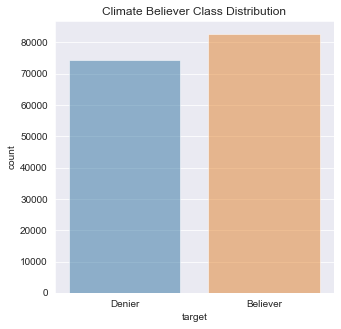

In [19]:
fig,ax = plt.subplots(figsize=(5,5))
sns.countplot(x = y, alpha = 0.5)
plt.xticks([0,1], ['Denier', 'Believer'])
plt.title("Climate Believer Class Distribution")
plt.show()

In [9]:
definitive_hashtags = ['climatechangeisreal', 'actonclimate', 'extinctionrebellion', 'climateemergency', 
                 'climateactionnow', 'capitalism', 'public_health', 'climateaction', 'humanityextinction',
                 'activism', 'noplanetb', 'savetheplanet', 'climateaction','climatechangeisfalse', 
                 'climatechangenotreal', 'climatechangehoax','globalwarminghoax', 'tcot', 'ccot', 'tlot', 
                 'pjnet', 'rednationrising', 'votered','libtard', 'libtards', 'maga', 'climatedeniers', 
                 'climatehoax', 'globalcooling','climatechangescam', 'climatehysteria', 'globalwarmingisahoax', 
                 'globalwarmingscam', 'globalcooling']

In [10]:
# create stop word list from default list, punctuation, and hashtags used to create classifcation params
stopwords_list = stopwords.words('english') + (list(string.punctuation) + 
                                               definitive_hashtags)

In [11]:
bel_class = ''
den_class = ''
for idx in range(len(X)):
    if y[idx] == 1:
        bel_class += ' ' + X[idx] 
    else:
        den_class += ' ' + X[idx]

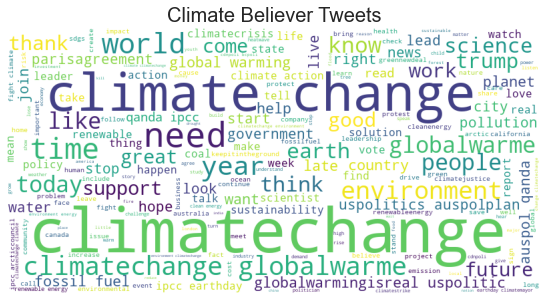

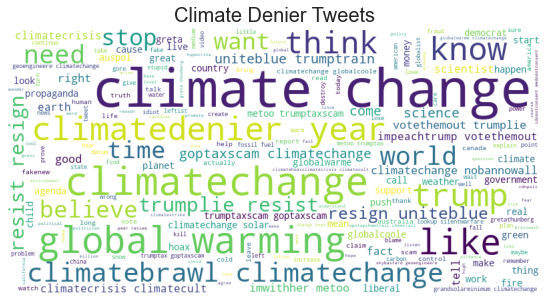

In [12]:
# https://github.com/JoeBrowz/climate-prop/blob/main/EDA_Notebook.ipynb

bel_cloud = WordCloud(width=800, height=400, min_word_length=4,
                      background_color='white',stopwords=stopwords_list + ['amp']).generate(bel_class)

den_cloud = WordCloud(width=800, height=400, min_word_length=4,
                      background_color='white',stopwords=stopwords_list + ['amp', 'people']).generate(den_class)

plt.figure(figsize=(8,4), facecolor=None)
plt.imshow(bel_cloud)
plt.axis('off')
plt.title('Climate Believer Tweets', fontdict={'fontsize': 20})
plt.tight_layout(pad=0)
plt.show()

plt.figure(figsize=(8,4), facecolor=None)
plt.imshow(den_cloud)
plt.axis('off')
plt.title('Climate Denier Tweets', fontdict={'fontsize': 20})
plt.tight_layout(pad=0)
plt.show()

## Prediction Data EDA

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150798 entries, 0 to 150797
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   150798 non-null  int64  
 1   text                 150798 non-null  object 
 2   location             150798 non-null  object 
 3   total_pop            150798 non-null  float64
 4   women                150798 non-null  float64
 5   hispanic             150798 non-null  float64
 6   white                150798 non-null  float64
 7   black                150798 non-null  float64
 8   native               150798 non-null  float64
 9   asian                150798 non-null  float64
 10  pacific              150798 non-null  float64
 11  income_per_cap       150798 non-null  float64
 12  poverty              150798 non-null  float64
 13  unemployment         150798 non-null  float64
 14  democrats            150798 non-null  float64
 15  republicans      

In [21]:
df2['location'].value_counts() # 1791 unique locations in the US

District of Columbia, DC    9268
Los Angeles, CA             7849
New York, NY                6857
King, WA                    3625
Cook, IL                    3618
                            ... 
Franklin, VT                   1
Hamilton, NY                   1
Louisa, IA                     1
Knox, NE                       1
Bedford, TN                    1
Name: location, Length: 1788, dtype: int64

In [22]:
df2['location'].value_counts()[0:20] # top 20 locations

District of Columbia, DC    9268
Los Angeles, CA             7849
New York, NY                6857
King, WA                    3625
Cook, IL                    3618
San Francisco, CA           3165
Multnomah, OR               3077
San Diego, CA               2891
Suffolk, MA                 2789
Maricopa, AZ                2614
Harris, TX                  2586
Kings, NY                   2408
Alameda, CA                 2344
Travis, TX                  2204
Santa Clara, CA             2164
Miami-Dade, FL              1943
Orange, CA                  1853
Denver, CO                  1852
Philadelphia, PA            1708
Fulton, GA                  1698
Name: location, dtype: int64

In [25]:
df2['political_inclination'] = df2.apply(lambda x: 'left' if x['democrats'] > 50 else 'right', axis=1)

In [26]:
df2['political_inclination']

0          left
1         right
2          left
3          left
4          left
          ...  
150793     left
150794     left
150795     left
150796     left
150797     left
Name: political_inclination, Length: 150798, dtype: object

In [27]:
df2.value_counts('political_inclination')

political_inclination
left     118919
right     31879
dtype: int64

In [28]:
n=len(df2)
democrats=len(df2[df2['political_inclination']=='left'])
republicans=len(df2[df2['political_inclination']=='right'])

print("Democrats %: ",round(democrats*100/n,1))
print("Republicans %: ",round(republicans*100/n,1))

Democrats %:  78.9
Republicans %:  21.1


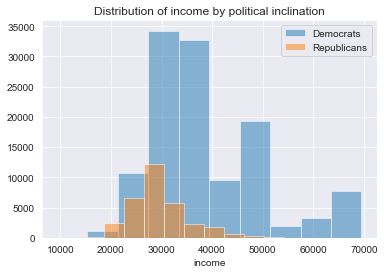

In [61]:
# Income distribution by political inclination

plt.hist('income_per_cap', data=df2[df2['political_inclination'] == 'left'], alpha=0.5, label='Democrats');
plt.hist('income_per_cap', data=df2[df2['political_inclination'] == 'right'], alpha=0.5, label='Republicans');
plt.title('Distribution of income by political inclination');
plt.xlabel('income');
plt.legend();

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150798 entries, 0 to 150797
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     150798 non-null  int64  
 1   text                   150798 non-null  object 
 2   location               150798 non-null  object 
 3   total_pop              150798 non-null  float64
 4   women                  150798 non-null  float64
 5   hispanic               150798 non-null  float64
 6   white                  150798 non-null  float64
 7   black                  150798 non-null  float64
 8   native                 150798 non-null  float64
 9   asian                  150798 non-null  float64
 10  pacific                150798 non-null  float64
 11  income_per_cap         150798 non-null  float64
 12  poverty                150798 non-null  float64
 13  unemployment           150798 non-null  float64
 14  democrats              150798 non-nu

In [34]:
num=['women', 'hispanic','white','black','native','asian',
    'pacific','income_per_cap','poverty','unemployment',
     'democrats','republicans','voting_age_citizens']

In [35]:
corr_df=df2[num]  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

                        women  hispanic     white     black    native  \
women                1.000000 -0.142428 -0.183368  0.593062 -0.083922   
hispanic            -0.142428  1.000000 -0.684790 -0.213746 -0.018635   
white               -0.183368 -0.684790  1.000000 -0.411709  0.044522   
black                0.593062 -0.213746 -0.411709  1.000000 -0.123718   
native              -0.083922 -0.018635  0.044522 -0.123718  1.000000   
asian               -0.223597  0.176727 -0.424784 -0.229424 -0.102655   
pacific             -0.206457 -0.010786 -0.118755 -0.191719  0.000178   
income_per_cap       0.240685 -0.128811 -0.120019  0.078426 -0.131699   
poverty              0.308981  0.219231 -0.361526  0.450162  0.095339   
unemployment         0.341406  0.230918 -0.454401  0.481392  0.076943   
democrats            0.376335  0.111437 -0.567236  0.457666 -0.137366   
republicans         -0.345040 -0.103519  0.545076 -0.426440  0.125729   
voting_age_citizens  0.129270 -0.779888  0.666636  

In [37]:
print(cor > 0.5)

                     women  hispanic  white  black  native  asian  pacific  \
women                 True     False  False   True   False  False    False   
hispanic             False      True  False  False   False  False    False   
white                False     False   True  False   False  False    False   
black                 True     False  False   True   False  False    False   
native               False     False  False  False    True  False    False   
asian                False     False  False  False   False   True    False   
pacific              False     False  False  False   False  False     True   
income_per_cap       False     False  False  False   False  False    False   
poverty              False     False  False  False   False  False    False   
unemployment         False     False  False  False   False  False    False   
democrats            False     False  False  False   False  False    False   
republicans          False     False   True  False   False  Fals

In [39]:
print(cor < -0.5)

                     women  hispanic  white  black  native  asian  pacific  \
women                False     False  False  False   False  False    False   
hispanic             False     False   True  False   False  False    False   
white                False      True  False  False   False  False    False   
black                False     False  False  False   False  False    False   
native               False     False  False  False   False  False    False   
asian                False     False  False  False   False  False    False   
pacific              False     False  False  False   False  False    False   
income_per_cap       False     False  False  False   False  False    False   
poverty              False     False  False  False   False  False    False   
unemployment         False     False  False  False   False  False    False   
democrats            False     False   True  False   False  False    False   
republicans          False     False  False  False   False  Fals

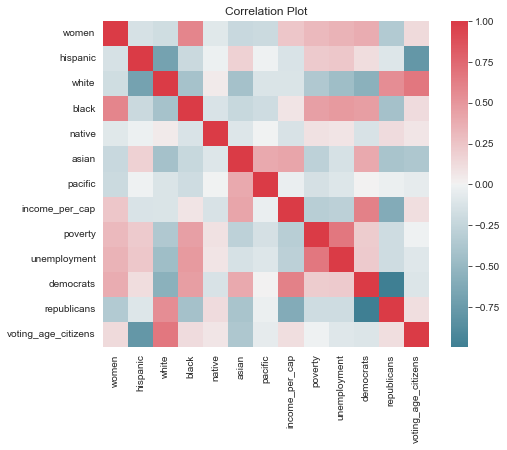

In [36]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [53]:
cols = [0,1]
df2.drop(df2.columns[cols], axis=1, inplace=True)

In [54]:
df2.describe()

,women,hispanic,white,black,native,asian,pacific,income_per_cap,poverty,unemployment,democrats,republicans,voting_age_citizens
count,150798.000000,150798.000000,150798.000000,150798.000000,150798.000000,150798.000000,150798.000000,150798.000000,150798.000000,150798.000000,150798.00000,150798.000000,150798.000000
mean,50.995648,20.226457,53.369165,14.666376,0.465126,8.201924,0.194709,36981.415994,14.796721,6.572524,63.42260,33.148461,69.815392
std,1.138818,15.184676,19.462370,13.725286,1.842690,7.855467,0.682386,11349.483725,4.414344,1.624868,16.97901,16.721325,5.653711
min,33.900000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,9334.000000,2.400000,0.300000,7.80000,4.000000,46.200000
25%,50.300000,8.400000,36.000000,5.100000,0.100000,3.400000,0.000000,29797.000000,11.700000,5.400000,52.00000,21.600000,66.300000
50%,50.900000,15.300000,49.300000,9.500000,0.200000,5.900000,0.000000,33722.000000,15.700000,6.400000,63.00000,33.100000,70.600000
75%,51.700000,28.200000,69.600000,20.200000,0.300000,11.800000,0.200000,41363.000000,17.300000,7.800000,76.90000,43.900000,74.200000
max,56.600000,99.200000,99.400000,81.500000,90.300000,41.800000,11.400000,69529.000000,51.900000,25.900000,93.40000,91.400000,90.700000
